# Clean up the big .csv file for easier use with my other codes

### Run the compileOCdata.ipynb first

I will use RA, Dec, coordinates from Simbad when possible.

The final file should have columns with IDs from all sources (as available), RA, Dec, distance, Age, Metallicity, Mass, Rgc, Rhm (all as available)

In [1]:
import pandas as pd
import numpy as np
import sys
import time
import re

from astropy.coordinates import SkyCoord
from astropy import units 

from astroquery.simbad import Simbad
Simbad.TIMEOUT = 300 # sets the timeout to 60s

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 100)

%matplotlib inline

In [2]:
matchCoord = True

## Get the coordinates

In [3]:
#it turns out that Simbad coordinates are not great.  So I actually don't need to do this...
#BUT I want a way to know which stars have a good Simbad match and which don't ... so I will do this anyway
def getSimbadRADec(match_ID):

    RA = np.full(len(match_ID), np.nan, dtype='object')
    Dec = np.full(len(match_ID), np.nan, dtype='object')


#     result_table = Simbad.query_objects(match_ID) #stupidly, this does not return blank rows for missing data!
# So I'm trying to go one line at a time, but of course Simbad doesn't like that... it rejects my connection when
# I have too many requests (and what is too many?  and how long should I wait?)
    for i, ID in enumerate(match_ID):
        result_table = Simbad.query_object(ID)
        if (result_table):
            #print(result_table.columns)
            if (len(result_table) > 0):
                row = result_table[0]
                RA[i] = row['RA']
                Dec[i] = row['DEC']
        print(f'{i} {float(i)/len(match_ID):5.3f}, {ID} {RA[i]} {Dec[i]} -- ', end='')
        if (i>0 and i % 50 == 0):
            time.sleep(20)
            print('\n\n')
        #time.sleep(0.1)

        
    return RA, Dec

In [4]:
def getCoord(row):

    if (pd.notna(row['_RAJ2000_cantat-gaudin']) and pd.notna(row['_DEJ2000_cantat-gaudin'])):
        return SkyCoord(ra=row['_RAJ2000_cantat-gaudin']+' hours', dec=row['_DEJ2000_cantat-gaudin']+' degree', frame='icrs')
    
    elif (pd.notna(row['ra_mwsc']) and pd.notna(row['dec_mwsc'])):
        return SkyCoord(ra=row['ra_mwsc']+' hours', dec=row['dec_mwsc']+' degree', frame='icrs')
        
    elif (pd.notna(row['RA[hr]_kharchenko']) and pd.notna(row['Dec[deg]_kharchenko'])):
        return SkyCoord(ra=row['RA[hr]_kharchenko']*units.hourangle, dec=row['Dec[deg]_kharchenko']*units.degree, frame='icrs')

    elif (pd.notna(row['GLON[deg]_piskunov']) and pd.notna(row['GLAT[deg]_piskunov'])):
        return SkyCoord(l=row['GLON[deg]_piskunov']*units.degree, b=row['GLAT[deg]_piskunov']*units.degree, frame='galactic').icrs

    elif (pd.notna(row['ra_lynga']) and pd.notna(row['dec_lynga'])):
        return SkyCoord(ra=row['ra_lynga']*units.degree, dec=row['dec_lynga']*units.degree, frame='icrs')
    
    elif (pd.notna(row['_RA[deg]_vandenbergh']) and pd.notna(row['_Dec[deg]_vandenbergh'])):
        return SkyCoord(ra=row['_Dec[deg]_vandenbergh']*units.degree, dec=row['_Dec[deg]_vandenbergh']*units.degree, frame='icrs')

    elif (pd.notna(row['RA_2000_webda']) and pd.notna(row['Dec_2000_webda'])):
        return SkyCoord(ra=row['RA_2000_webda']+' hours', dec=row['Dec_2000_webda']+' degree', frame='icrs')
            
    elif (pd.notna(row['GLON[deg]_cantat-gaudin']) and pd.notna(row['GLAT[deg]_cantat-gaudin'])):
        return SkyCoord(l=row['GLON[deg]_cantat-gaudin']*units.degree, b=row['GLAT[deg]_cantat-gaudin']*units.degree, frame='galactic').icrs

    elif (pd.notna(row['l_webda']) and pd.notna(row['b_webda'])):
        return SkyCoord(l=row['l_webda']*units.degree, b=row['b_webda']*units.degree, frame='galactic').icrs
    
    else:
        print('NO RA, Dec : ', row['Simbad_ID'])
        return False

In [5]:
OC_df = pd.read_csv('OCcompiled.csv')
OC_df

,Simbad_ID,Name_mwsc,broad_type_mwsc,cluster_status_mwsc,ra_mwsc,dec_mwsc,lii_mwsc,bii_mwsc,core_radius_mwsc,central_radius_mwsc,cluster_radius_mwsc,pm_ra_mwsc,pm_dec_mwsc,pm_tot_error_mwsc,rad_vel_mwsc,rad_vel_error_mwsc,num_rad_vel_stars_mwsc,num_core_stars_mwsc,num_central_stars_mwsc,num_cluster_stars_mwsc,distance_mwsc,e_bv_mwsc,distance_modulus_mwsc,e_jk_mwsc,e_jh_mwsc,delta_h_mwsc,log_age_mwsc,log_age_error_mwsc,num_log_age_stars_mwsc,king_core_radius_mwsc,king_core_radius_error_mwsc,king_tidal_radius_mwsc,king_tidal_radius_error_mwsc,king_norm_factor_mwsc,king_norm_factor_error_mwsc,reference_code_mwsc,cluster_type_mwsc,metallicity_mwsc,metallicity_error_mwsc,num_metallicity_stars_mwsc,comments_mwsc,class_mwsc,Name_webda,RA_2000_webda,Dec_2000_webda,l_webda,b_webda,Dist_webda,Mod_webda,EB-V_webda,Age_webda,ST_webda,Z_webda,Diam_webda,Fe/H_webda,MRV_webda,pm RA_webda,pm Dec_webda,Measures_webda,Stars_webda,COCD_piskunov,Name_piskunov,GLON[deg]_piskunov,GLAT[deg]_piskunov,DistMod_piskunov,E(B-V)_piskunov,Dist[pc]_piskunov,logt[yr]_piskunov,rt[pc]_piskunov,e_rt[pc]_piskunov,logM[MSun]_piskunov,e_logM[MSun]_piskunov,rtA[pc]_piskunov,e_rtA[pc]_piskunov,logMA[MSun]_piskunov,e_logMA[MSun]_piskunov,MWSC_kharchenko,Name_kharchenko,Type_kharchenko,n_Type_kharchenko,RA[hr]_kharchenko,Dec[deg]_kharchenko,GLON[deg]_kharchenko,GLAT[deg]_kharchenko,r0[deg]_kharchenko,r1[deg]_kharchenko,r2[deg]_kharchenko,pmRA[mas/yr]_kharchenko,pmDec[mas/yr]_kharchenko,e_pm[mas/yr]_kharchenko,RV[km/s]_kharchenko,e_RV[km/s]_kharchenko,n_RV[km/s]_kharchenko,N1sr0_kharchenko,N1sr1_kharchenko,N1sr2_kharchenko,d[pc]_kharchenko,E(B-V)_kharchenko,appDistMod[mag]_kharchenko,E(J-Ks)_kharchenko,E(J-H)_kharchenko,dH_kharchenko,logt[yr]_kharchenko,e_logt[yr]_kharchenko,Nt_kharchenko,rc[pc]_kharchenko,e_rc[pc]_kharchenko,rt[pc]_kharchenko,e_rt[pc]_kharchenko,k[pc-2]_kharchenko,e_k[pc-2]_kharchenko,Src_kharchenko,SType_kharchenko,[Fe/H][Sun]_kharchenko,e_[Fe/H][Sun]_kharchenko,n_[Fe/H]_kharchenko,Name_salaris,dV_salaris,err_dV_salaris,[Fe/H]_salaris,err_[Fe/H]_salaris,t[Gyr]_salaris,err_t_salaris,Rgc[kpc]_salaris,z[pc]_salaris,flag_salaris,tJP94[Gyr]_salaris,Seq_vandenbergh,Name_vandenbergh,l[deg]_vandenbergh,Diam[pc]_vandenbergh,R[pc]_vandenbergh,Z[pc]_vandenbergh,E(B-V)_vandenbergh,logT[yr]_vandenbergh,SimbadName_vandenbergh,_RA[deg]_vandenbergh,_Dec[deg]_vandenbergh,_RAJ2000_cantat-gaudin,_DEJ2000_cantat-gaudin,Name_cantat-gaudin,RAJ2000[deg]_cantat-gaudin,DEJ2000[deg]_cantat-gaudin,GLON[deg]_cantat-gaudin,GLAT[deg]_cantat-gaudin,r50[deg]_cantat-gaudin,Nstars_cantat-gaudin,pmRA[mas/yr]_cantat-gaudin,pmDE[mas/yr]_cantat-gaudin,plx[mas]_cantat-gaudin,dmode[pc]_cantat-gaudin,Rgc[pc]_cantat-gaudin,SimbadName_cantat-gaudin,Name_lynga,ra_lynga,dec_lynga,distance_lynga,log_age_lynga,angular_diameter_lynga,alt_name_lynga,lii_lynga,bii_lynga,iau_num_lynga,seq_code_lynga,seq_num_lynga,prec_ra_lynga,prec_dec_lynga,lund_record_num_lynga,ocl_num_lynga,ref_angular_diameter_lynga,ref_distance_lynga,ref_log_age_lynga,metallicity_lynga,ref_metallicity_lynga,e_bv_lynga,ref_e_bv_lynga,type_flag_lynga,ref_type_flag_lynga,tr_concent_class_lynga,tr_range_class_lynga,tr_richness_class_lynga,tr_nebulosity_lynga,sb_bs_mag_lynga,sb_spect_code_lynga,sb_total_mag_lynga,sk_total_mag_lynga,sk_bv_color_lynga,sk_num_stars_lynga,ja_star_num_lynga,ja_class_lynga,ja_max_class_lynga,ja_richness_lynga,ja_e_bv_lynga,ref_ja_e_bv_lynga,ja_bv_turnoff_lynga,ref_ja_bv_turnoff_lynga,ly_tr_concent_class_lynga,ly_tr_range_class_lynga,ly_tr_richness_class_lynga,ly_tr_nebulosity_lynga,ly_member_stars_lynga,ly_angular_diameter_lynga,ly_refs_flag_lynga,radvel_weight_lynga,radvel_lynga,radvel_weight_class_lynga,ref_radvel1_lynga,ref_radvel2_lynga,ref_radvel3_lynga,ref_radvel4_lynga,ref_radvel5_lynga,basel_spect_code_lynga,basel_color_type_lynga,neg_ra_tracer_lynga,neg_lii_tracer_lynga,neg_seq_num_tracer_lynga,pos_ra_tracer_lynga,pos_lii_tracer_lynga,pos_seq_num_tracer_lynga,jdl_distance_lynga,jdl_distance_weight

In [6]:
RA = np.full(len(OC_df), np.nan, dtype='object')
Dec = np.full(len(OC_df), np.nan, dtype='object')
for index, row in OC_df.iterrows():
    #RA and Dec
    c = getCoord(row)
    if (c):
        RA[index] = c.ra.to_string(sep=' ', pad=True, unit=units.hour, precision=3)
        Dec[index] = c.dec.to_string(sep=' ', pad=True, unit=units.degree, precision=3)
    else:
        print('WARNING: no coordinates!', row['Simbad_ID'])

In [7]:
#this takes a while...
if (matchCoord):
    RA_Simbad, Dec_Simbad = getSimbadRADec(OC_df['Simbad_ID'].values)
    

0 0.000, [KPS2012]_MWSC_4688 23 51 54 -86 43.2 -- 1 0.000, [KPS2012]_MWSC_5684 nan nan -- 2 0.001, [KPS2012]_MWSC_5692 nan nan -- 3 0.001, [KPS2012]_MWSC_4005 00 11 28 -85 28.8 -- 4 0.001, [KPS2012]_MWSC_4176 14 27 18 -85 25.2 -- 5 0.001, ESO_8-6 14 56 54 -83 26.7 -- 6 0.002, [KPS2012]_MWSC_4219 15 42 14 -83 11.7 -- 7 0.002, [KPS2012]_MWSC_5575 nan nan -- 8 0.002, [KPS2012]_MWSC_4682 23 43 23 -82 57.6 -- 9 0.003, [KPS2012]_MWSC_5685 nan nan -- 10 0.003, [KPS2012]_MWSC_5681 nan nan -- 11 0.003, [KPS2012]_MWSC_2014 12 20 06 -81 30.6 -- 12 0.004, [KPS2012]_MWSC_2064 12 45 43 -81 15.5 -- 13 0.004, [KPS2012]_MWSC_2049 12 34 55 -80 57.0 -- 14 0.004, [KPS2012]_MWSC_5688 nan nan -- 15 0.004, ESO_26-2 20 26 38 -80 00.0 -- 16 0.005, [KPS2012]_MWSC_4137 09 26 12 -79 44.4 -- 17 0.005, Cl_Melotte_227 20 16 48 -79 02.4 -- 18 0.005, [KPS2012]_MWSC_5679 nan nan -- 19 0.006, [KPS2012]_MWSC_5572 nan nan -- 20 0.006, [KPS2012]_MWSC_5749 nan nan -- 21 0.006, ESO_21-6 14 15 52 -78 30.9 -- 22 0.007, [KPS201

151 0.045, Cl_Hogg_15 12 43 36 -63 05.9 -- 152 0.045, [KPS2012]_MWSC_2134 13 33 50 -63 02.4 -- 153 0.046, C_1206-626 12 09 45.0 -62 59 17 -- 154 0.046, Cl_Dias_4 13 43 25 -63 00.0 -- 155 0.046, NGC_4609 12 42 18 -62 59.7 -- 156 0.047, IC_2944 11 38 20.00 -63 22 22.0 -- 157 0.047, NGC_5281 13 46 35 -62 55.0 -- 158 0.047, Ass_Cir_OB_1 14 45 -62.9 -- 159 0.047, [DBS2003]_129 12 15 24 -62 55.1 -- 160 0.048, NGC_5269 13 44 44.0 -62 54 54 -- 161 0.048, C_1437-626 14 41 29 -62 49.9 -- 162 0.048, [KPS2012]_MWSC_5696 nan nan -- 163 0.049, Cl_Trumpler_21 13 32.2 -62 48 -- 164 0.049, IC_2714 11 17 27 -62 44.0 -- 165 0.049, NGC_4184 12 13 34 -62 43.8 -- 166 0.050, [KPS2012]_MWSC_1959 11 36 58 -62 43.4 -- 167 0.050, C_1154-623 11 57 28 -62 43.0 -- 168 0.050, Cl_Danks_1 13 12 27 -62 42.1 -- 169 0.050, NGC_3036 09 49.2 -62 40 -- 170 0.051, Cl_Danks_2 13 12 55 -62 40.9 -- 171 0.051, [DBS2003]_85 13 18 31 -62 39.8 -- 172 0.051, [FSR2007]_1595 11 47 05.0 -62 38 13 -- 173 0.052, [KPR2005]_89 17 23.3 -62 

301 0.090, [KPR2005]_62 10 50 53 -60 06.0 -- 302 0.090, C_1045-598 10 47 15.2 -60 05 51 -- 303 0.090, NGC_5043 13 16.1 -60 04 -- 304 0.091, [KPS2012]_MWSC_2219 14 28 34 -60 01.2 -- 305 0.091, [KPS2012]_MWSC_5723 nan nan -- 306 0.091, Cl_Ruprecht_111 14 36 00 -59 58.8 -- 307 0.092, [KPS2012]_MWSC_4116 06 19 12 -59 58.2 -- 308 0.092, NGC_5299 nan nan -- 309 0.092, NGC_2132 05 55 19 -59 55.2 -- 310 0.092, Cl_Collinder_223 10 32 16 -60 01.2 -- 311 0.093, [DBS2003]_89 14 45 03 -59 49.5 -- 312 0.093, Cl_Feinstein_1 11 06 43 -59 49.2 -- 313 0.093, C_1225-595 12 28 44 -59 48.6 -- 314 0.094, Cl_Loden_821 13 24 21 -59 44.0 -- 315 0.094, Cl_Loden_1095 13 53 37 -59 44.7 -- 316 0.094, C_1402-594 14 05 42.00 -59 42 00.0 -- 317 0.095, C_1405-594 14 09 22 -59 43.5 -- 318 0.095, ESO_130-13 12 23 04 -59 39.9 -- 319 0.095, NAME_HD_135159_Group 15 16 44 -59 39.3 -- 320 0.095, NGC_5606 14 27 47 -59 38.4 -- 321 0.096, [KPS2012]_MWSC_2289 15 20 58 -59 37.2 -- 322 0.096, [DBS2003]_51 10 32 58 -59 37.4 -- 323 

451 0.135, Cl_Loden_189 10 50.4 -56 25 -- 452 0.135, [DBS2003]_141 15 28 32 -56 22.5 -- 453 0.135, [KPS2012]_MWSC_2109 13 19 47 -56 21.1 -- 454 0.135, C_0920-560 09 21 55 -56 19.0 -- 455 0.136, C_0949-560 09 51 36 -56 18.6 -- 456 0.136, Cl_VDBH_58 09 10 12.0 -56 15 43 -- 457 0.136, [KPS2012]_MWSC_1689 09 33 56 -56 14.9 -- 458 0.137, [KPS2012]_MWSC_2107 13 19 37 -56 10.8 -- 459 0.137, [KPS2012]_MWSC_1789 10 18 59 -56 10.2 -- 460 0.137, [KPS2012]_MWSC_2025 12 24 16 -56 09.9 -- 461 0.137, [KPS2012]_MWSC_2233 14 34 37 -56 06.9 -- 462 0.138, ESO_165-9 09 05.2 -55 58 -- 463 0.138, NAME_SCHUSTER_CL 10 04 36 -55 51.4 -- 464 0.138, Cl_Loden_1 10 05 14 -55 48.3 -- 465 0.139, [KPS2012]_MWSC_1716 09 48 36 -55 47.4 -- 466 0.139, NGC_3960 11 50 33 -55 40.4 -- 467 0.139, NGC_5823 15 05 31 -55 35.7 -- 468 0.140, [KPR2005]_66 11 13.6 -55 25 -- 469 0.140, C_1002-552 10 04 18.00 -55 26 00.0 -- 470 0.140, [SSW94]_c 10 41.5 -55 18 -- 471 0.140, Cl_Lynga_4 15 33 20 -55 14.4 -- 472 0.141, [KPS2012]_MWSC_1818

601 0.179, ESO_211-9 09 16 44 -50 17.0 -- 602 0.180, [KPS2012]_MWSC_1730 09 56 24 -50 16.2 -- 603 0.180, ESO_211-3 08 51 36 -50 14.7 -- 604 0.180, Cl_Lynga_8 16 20 04 -50 13.0 -- 605 0.180, C_0930-499 09 31 52 -50 12.9 -- 606 0.181, [KPS2012]_MWSC_2321 15 48 40 -50 12.9 -- 607 0.181, [DBS2003]_164 16 19 23 -50 09.5 -- 608 0.181, [KPS2012]_MWSC_2420 16 30 25 -50 07.5 -- 609 0.182, [KPS2012]_MWSC_1511 08 37 01 -50 02.4 -- 610 0.182, NAME_HD_80077_Group 09 15 53.0 -50 01 00 -- 611 0.182, [DBS2003]_166 16 21 27 -50 00.7 -- 612 0.183, IC_4651 17 24 49 -49 56.0 -- 613 0.183, [KPS2012]_MWSC_4545 20 07 50 -49 51.6 -- 614 0.183, [DBS2003]_102 16 15 01 -49 50.7 -- 615 0.183, NGC_6167 16 34 34 -49 46.3 -- 616 0.184, [KPS2012]_MWSC_2195 14 00 18 -49 45.9 -- 617 0.184, [KPS2012]_MWSC_2419 16 29 49 -49 45.1 -- 618 0.184, [KPS2012]_MWSC_1640 09 14 40 -49 44.7 -- 619 0.185, [DBS2003]_170 16 28 58.0 -49 36 27 -- 620 0.185, Cl_VDBH_85 10 01 52 -49 35.1 -- 621 0.185, [DBS2003]_167 16 23 24 -49 32.5 -- 62

751 0.224, Cl_Lynga_13 16 48 56 -43 25.7 -- 752 0.224, [DBS2003]_175 16 52 36 -43 23.5 -- 753 0.225, C_0840-432 08 41 39 -43 22.0 -- 754 0.225, NGC_6192 16 40 23 -43 22.0 -- 755 0.225, C_0855-430 08 57 08 -43 15.0 -- 756 0.225, NGC_3680 11 25 38 -43 14.6 -- 757 0.226, [KPS2012]_MWSC_2145 13 38 00 -43 10.8 -- 758 0.226, [KPS2012]_MWSC_1837 10 39 58 -43 07.4 -- 759 0.226, NGC_6322 17 18 25 -42 56.0 -- 760 0.227, [KPS2012]_MWSC_5604 nan nan -- 761 0.227, [KPS2012]_MWSC_2185 13 57 30 -42 52.2 -- 762 0.227, ESO_311-14 07 49.4 -42 42 -- 763 0.228, ESO_282-26 19 13 52 -42 39.0 -- 764 0.228, [KPS2012]_MWSC_1608 08 58 06 -42 36.0 -- 765 0.228, [DBS2003]_176 16 59 23 -42 34.4 -- 766 0.228, C_0846-423 08 47 54 -42 27.0 -- 767 0.229, [FSR2007]_1744 16 51 36.0 -42 24 55 -- 768 0.229, ESO_309-3 06 50.7 -42 23 -- 769 0.229, [KPS2012]_MWSC_1512 08 37 03 -42 21.9 -- 770 0.230, [KPS2012]_MWSC_1518 08 38 17 -42 21.0 -- 771 0.230, [KPS2012]_MWSC_5744 nan nan -- 772 0.230, [KPS2012]_MWSC_1726 09 54 34 -42 

901 0.269, [KPS2012]_MWSC_1405 07 59 45 -36 11.4 -- 902 0.269, [KPS2012]_MWSC_2742 17 54 00 -36 08.7 -- 903 0.269, Teutsch_50 08 07 08.1 -36 03 48 -- 904 0.270, [KPS2012]_MWSC_1683 09 32 22 -35 58.8 -- 905 0.270, C_0842-357 08 44 36 -35 53.1 -- 906 0.270, Ass_Pup_OB_3 08 18.1 -35 46 -- 907 0.271, [KPS2012]_MWSC_5706 nan nan -- 908 0.271, IC_1023 14 32 25 -35 48.2 -- 909 0.271, [KPS2012]_MWSC_5713 nan nan -- 910 0.271, [KPS2012]_MWSC_1541 08 42 56 -35 47.1 -- 911 0.272, [IBP2002]_CC08 08 19 10 -35 39.0 -- 912 0.272, [KPR2005]_45 08 15 50 -35 39.0 -- 913 0.272, [KPS2012]_MWSC_2291 15 25 01 -35 38.1 -- 914 0.273, C_0740-354 07 43.0 -35 36 -- 915 0.273, [KPR2005]_88 17 06 47 -35 36.0 -- 916 0.273, Cl_Bochum_13 17 17 24 -35 33.0 -- 917 0.273, ESO_371-25 08 53 00 -35 28.0 -- 918 0.274, [KPS2012]_MWSC_1760 10 05 35 -35 21.9 -- 919 0.274, ESO_367-10 07 17 02 -35 17.4 -- 920 0.274, C_1753-353 17 56.8 -35 16 -- 921 0.275, NGC_6455 nan nan -- 922 0.275, NGC_6396 17 37 36 -35 01.6 -- 923 0.275, [K

1051 0.313, NGC_2627 08 37 15 -29 57.3 -- 1052 0.314, [KPS2012]_MWSC_4248 16 12 45 -29 54.3 -- 1053 0.314, NGC_2533 08 07 04 -29 53.0 -- 1054 0.314, ESO_456-5 17 53.1 -29 53 -- 1055 0.315, C_0748-297 07 50 30 -29 50.7 -- 1056 0.315, ESO_430-9 08 02 24 -29 46.0 -- 1057 0.315, NGC_2571 08 18 56 -29 45.0 -- 1058 0.316, [KPS2012]_MWSC_1642 09 15 41 -29 40.5 -- 1059 0.316, ESO_455-40 17 47 11.50 -29 35 24.0 -- 1060 0.316, [KPS2012]_MWSC_5071 nan nan -- 1061 0.316, ESO_456-72 18 12 29 -29 34.0 -- 1062 0.317, C_0639-295 06 41 01 -29 33.0 -- 1063 0.317, C_1749-295 17 52 43 -29 33.0 -- 1064 0.317, NGC_2587 08 23 26 -29 29.6 -- 1065 0.318, ESO_428-24 07 22 55.0 -29 30 00 -- 1066 0.318, C_1725-294 17 28 32 -29 29.8 -- 1067 0.318, ESO_426-33 06 42 06 -29 26.7 -- 1068 0.319, [KPS2012]_MWSC_1731 09 56 38 -29 26.7 -- 1069 0.319, ESO_442-4 12 34 05 -29 24.6 -- 1070 0.319, ESO_437-61 10 48 03 -29 23.5 -- 1071 0.319, ESO_447-29 14 37 21 -29 23.7 -- 1072 0.320, ESO_464-9 20 59 37 -29 23.2 -- 1073 0.320, 

1201 0.358, Dutra-Cl_Bica_60 nan nan -- 1202 0.358, ESO_525-8 19 27 11 -23 35.4 -- 1203 0.359, Cl_Ruprecht_139 18 01.0 -23 32 -- 1204 0.359, [KPS2012]_MWSC_1601 08 56 13 -23 26.1 -- 1205 0.359, C_0728-232 07 30 36 -23 23.0 -- 1206 0.360, C_0734-232 07 36 47 -23 21.3 -- 1207 0.360, NGC_6546 18 07 22 -23 17.8 -- 1208 0.360, [KPS2012]_MWSC_0860 06 25 05 -23 18.6 -- 1209 0.361, [KPS2012]_MWSC_1440 08 10 46 -23 18.3 -- 1210 0.361, [KPS2012]_MWSC_5311 nan nan -- 1211 0.361, [KPS2012]_MWSC_2751 17 56 26 -23 11.5 -- 1212 0.361, Cl_Ruprecht_17 07 23 38 -23 11.1 -- 1213 0.362, [KPR2005]_39 07 33.0 -22 57 -- 1214 0.362, [KPS2012]_MWSC_5717 nan nan -- 1215 0.362, [FSR2007]_0023 17 57 35.0 -22 52 32 -- 1216 0.363, ESO_561-5 07 59.3 -22 41 -- 1217 0.363, C_0716-225 07 17 58 -22 40.0 -- 1218 0.363, M_21 18 04 13 -22 29.4 -- 1219 0.364, Cl_Ruprecht_39 07 52 19 -22 26.8 -- 1220 0.364, [DBS2003]_10 07 35 27 -22 23.9 -- 1221 0.364, [KPS2012]_MWSC_5316 nan nan -- 1222 0.364, [DBS2003]_13 08 12 15 -22 20.9

1351 0.403, C_1829-160 18 32 06 -16 00.6 -- 1352 0.403, Ass_Sgr_OB_6 18 12 -16.0 -- 1353 0.404, [KPS2012]_MWSC_2489 16 55 44 -15 59.7 -- 1354 0.404, [KPS2012]_MWSC_1109 07 07 22 -15 58.8 -- 1355 0.404, [KPS2012]_MWSC_5312 nan nan -- 1356 0.404, [KPS2012]_MWSC_1269 07 34 31 -15 56.1 -- 1357 0.405, [KPS2012]_MWSC_1163 07 17 11 -15 47.7 -- 1358 0.405, [KPS2012]_MWSC_2942 18 32 05 -15 41.2 -- 1359 0.405, Cl_Ruprecht_26 07 37 12 -15 39.0 -- 1360 0.406, NGC_2360 07 17 43 -15 38.5 -- 1361 0.406, [KPS2012]_MWSC_2609 17 29 46 -15 38.1 -- 1362 0.406, NGC_2414 07 33 12 -15 27.2 -- 1363 0.407, [KPS2012]_MWSC_1252 07 31 11 -15 25.7 -- 1364 0.407, C_0726-153 07 28 22 -15 24.3 -- 1365 0.407, [KPS2012]_MWSC_1122 07 08 28 -15 21.9 -- 1366 0.407, C_0726-152 07 28 35 -15 21.9 -- 1367 0.408, [DBS2003]_1 07 30 40 -15 18.0 -- 1368 0.408, [KPS2012]_MWSC_4572 20 31 00 -15 10.5 -- 1369 0.408, [FSR2007]_0070 19 30 02.0 -15 10 02 -- 1370 0.409, [KPS2012]_MWSC_5319 nan nan -- 1371 0.409, Cl_Waterloo_7 07 26 08.0 

1501 0.448, [KPS2012]_MWSC_1390 07 57 47 -09 09.0 -- 1502 0.448, [KPS2012]_MWSC_2659 17 39 52 -09 06.6 -- 1503 0.448, [KPS2012]_MWSC_1048 06 59 20 -09 05.0 -- 1504 0.449, NGC_6728 18 58.8 -08 58 -- 1505 0.449, [KPS2012]_MWSC_0748 06 08 53 -08 56.8 -- 1506 0.449, [KPS2012]_MWSC_0827 06 16 31 -08 56.7 -- 1507 0.449, C_1633-088 16 36 25 -08 56.1 -- 1508 0.450, [KPS2012]_MWSC_5321 nan nan -- 1509 0.450, [KPS2012]_MWSC_1111 07 07 30 -08 51.9 -- 1510 0.450, [IBP2002]_CC04 07 00 32 -08 52.0 -- 1511 0.451, [FSR2007]_0041 17 03 30.0 -08 51 13 -- 1512 0.451, [KPS2012]_MWSC_1036 06 57 55 -08 44.7 -- 1513 0.451, [KPS2012]_MWSC_2846 18 13 48 -08 42.5 -- 1514 0.452, NGC_2349 07 10.8 -08 36 -- 1515 0.452, [KPS2012]_MWSC_2855 18 15 07 -08 27.0 -- 1516 0.452, Cl_Trumpler_34 18 39 48 -08 24.9 -- 1517 0.452, Cl_Dias_3 07 10 23 -08 23.7 -- 1518 0.453, M_50 07 02 47.5 -08 20 16 -- 1519 0.453, NGC_6664 18 36 37 -07 48.8 -- 1520 0.453, NAME_IRAS_06548-0815_Cluster 06 57 15 -08 19.8 -- 1521 0.454, [KPS2012]_M

1651 0.492, C_0646+004 06 48 54 +00 23.0 -- 1652 0.493, [KPS2012]_MWSC_5748 nan nan -- 1653 0.493, NGC_2112 05 53 45 +00 24.6 -- 1654 0.493, [KPS2012]_MWSC_5022 nan nan -- 1655 0.494, NGC_2301 06 51 45 +00 27.6 -- 1656 0.494, [KPS2012]_MWSC_0571 05 32 26 +00 31.8 -- 1657 0.494, [FSR2007]_0098 18 47 31.0 +00 36 51 -- 1658 0.494, [KPR2005]_22 06 14.5 +00 38 -- 1659 0.495, [KPS2012]_MWSC_1038 06 58 16 +00 53.0 -- 1660 0.495, [KPR2005]_18 05 26 10 +00 49.2 -- 1661 0.495, NGC_2324 07 04 07 +01 02.7 -- 1662 0.496, NGC_2189 06 12 07 +01 03.3 -- 1663 0.496, NGC_2262 06 39 40 +01 08.4 -- 1664 0.496, [KPS2012]_MWSC_1407 08 00 20 +01 15.6 -- 1665 0.497, [KPS2012]_MWSC_4317 17 10 28 +01 15.9 -- 1666 0.497, C_1745+013 17 48 06 +01 18.0 -- 1667 0.497, Teutsch_13 06 43 55.0 +01 24 09 -- 1668 0.497, [KPS2012]_MWSC_4547 20 12 13 +01 31.5 -- 1669 0.498, [KPS2012]_MWSC_0947 06 39 58 +01 32.0 -- 1670 0.498, [KPS2012]_MWSC_3054 19 09 03 +01 32.2 -- 1671 0.498, [KPS2012]_MWSC_1140 07 11 37 +01 36.3 -- 1672 

1801 0.537, NGC_2312 06 58 48 +10 16.8 -- 1802 0.537, NGC_6709 18 51 18 +10 19.1 -- 1803 0.538, NGC_6724 18 56 45.00 +10 26 47.0 -- 1804 0.538, [KPS2012]_MWSC_5645 nan nan -- 1805 0.538, NGC_2141 06 02 55 +10 26.8 -- 1806 0.539, [KPS2012]_MWSC_4602 21 02 46 +10 45.9 -- 1807 0.539, NAME_Poole_J1856+10.8 18 55 53 +10 46.4 -- 1808 0.539, NAME_Poole_J1855+10.8 18 55 08 +10 46.5 -- 1809 0.540, NGC_2259 06 38 34.4 +10 53 24 -- 1810 0.540, NGC_1662 04 48 27 +10 56.2 -- 1811 0.540, NGC_6525 18 02 00.0 +11 01 24 -- 1812 0.540, [FSR2007]_0979 06 31 18.0 +11 04 51 -- 1813 0.541, [KPS2012]_MWSC_2724 17 51 16 +11 09.7 -- 1814 0.541, NGC_6858 20 02 56.0 +11 15 30 -- 1815 0.541, Cl_Berkeley_43 19 15 30 +11 15.9 -- 1816 0.542, [KPS2012]_MWSC_0626 05 40 07 +11 27.6 -- 1817 0.542, Dol-Dzim_2 nan nan -- 1818 0.542, [KPS2012]_MWSC_0535 05 25 32 +11 35.6 -- 1819 0.542, NGC_6738 19 01.3 +11 37 -- 1820 0.543, Cl_Dias_8 19 52 10 +11 37.7 -- 1821 0.543, C_1924+115 19 25 25 +11 38.1 -- 1822 0.543, NGC_6837 19 5

1951 0.582, [FSR2007]_0894 06 04 05.0 +20 16 51 -- 1952 0.582, [KPS2012]_MWSC_5627 nan nan -- 1953 0.582, [KPS2012]_MWSC_0635 05 40 58 +20 21.4 -- 1954 0.583, C_1956+203 19 58 42 +20 29.0 -- 1955 0.583, Cl_Berkeley_23 06 33 28.5 +20 32 47 -- 1956 0.583, [FSR2007]_0902 06 18 19.0 +20 31 42 -- 1957 0.584, C_0607+206 06 10 55 +20 36.9 -- 1958 0.584, [KPS2012]_MWSC_5782 nan nan -- 1959 0.584, C_0552+208 05 55.2 +20 52 -- 1960 0.585, NGC_6873 20 07 41 +21 05.4 -- 1961 0.585, Cl_Czernik_40 19 42.6 +21 11 -- 1962 0.585, Cl_Dias_7 19 49 28 +21 10.0 -- 1963 0.585, NGC_6827 19 48 53.0 +21 11 52 -- 1964 0.586, [KPS2012]_MWSC_3145 19 37 28 +21 18.9 -- 1965 0.586, [FSR2007]_0841 05 06 18.0 +21 31 00 -- 1966 0.586, [KPS2012]_MWSC_0802 06 13 43 +21 33.1 -- 1967 0.587, NGC_2420 07 38 23 +21 34.4 -- 1968 0.587, Cl_Alessi_62 18 55 49.00 +21 34 49.0 -- 1969 0.587, [KPS2012]_MWSC_0393 04 34 36 +21 40.5 -- 1970 0.588, [KGZ2008]_77 05 43 52.3 +21 42 37 -- 1971 0.588, Cl_Berkeley_21 05 51 42 +21 47.0 -- 1972

2101 0.627, [KPR2005]_17 05 25 12 +30 10.2 -- 2102 0.627, [KPS2012]_MWSC_0480 05 10 58 +30 12.3 -- 2103 0.627, C_0545+302 05 49 00 +30 12.3 -- 2104 0.627, [KPS2012]_MWSC_5800 nan nan -- 2105 0.628, [FSR2007]_0839 06 03 58.0 +30 15 41 -- 2106 0.628, [KPS2012]_MWSC_1027 06 56 39 +30 28.7 -- 2107 0.628, NAME_Latham_1 13 11 12.0 +30 49 30 -- 2108 0.629, Kronberger_68 20 00 36.4 +30 35 23 -- 2109 0.629, Cl_Berkeley_17 05 20 37 +30 35.4 -- 2110 0.629, HHL_31 05 47 12.9 +30 36 12 -- 2111 0.630, [BDS2003]_74 05 38 47 +30 41.3 -- 2112 0.630, [KPS2012]_MWSC_3556 21 44 51 +30 45.6 -- 2113 0.630, [KPS2012]_MWSC_0726 06 05 24 +30 47.6 -- 2114 0.630, NAME_Skiff_J0507+30.8 05 07 12 +30 51.0 -- 2115 0.631, Kronberger_52 19 58 07.9 +30 53 18 -- 2116 0.631, [KPS2012]_MWSC_0622 05 39 27 +30 54.2 -- 2117 0.631, C_0424+308 04 28.0 +30 56 -- 2118 0.632, Teutsch_45 05 42 45.9 +30 57 33 -- 2119 0.632, [FSR2007]_0814 05 36 50.6 +31 12 39 -- 2120 0.632, Teutsch_124 20 18 21.2 +31 12 44 -- 2121 0.633, BD+01_4828

2251 0.671, [FSR2007]_0744 04 59 30.0 +38 00 42 -- 2252 0.672, [KPS2012]_MWSC_5558 nan nan -- 2253 0.672, NAME_Feibelman_1 20 17 47 +38 02.0 -- 2254 0.672, [KPS2012]_MWSC_0429 04 50 35 +38 08.0 -- 2255 0.673, C_2017+379 20 19 37 +38 08.5 -- 2256 0.673, [KPS2012]_MWSC_0358 04 18 13 +38 08.7 -- 2257 0.673, Teutsch_52 05 30 18.3 +38 13 51 -- 2258 0.673, Dol-Dzim_6 nan nan -- 2259 0.674, C_2005+382 20 06 42 +38 21.9 -- 2260 0.674, [KPS2012]_MWSC_0469 05 07 16 +38 24.6 -- 2261 0.674, [KPS2012]_MWSC_0384 04 29 53 +38 30.0 -- 2262 0.675, M_29 20 23 56 +38 31.4 -- 2263 0.675, [KPR2005]_113 21 12 00.0 +38 35 59 -- 2264 0.675, NAME_Skiff_J1942+38.6 19 42 24 +38 38.4 -- 2265 0.676, Cl_Berkeley_86 20 20 12 +38 41.4 -- 2266 0.676, DSH_J0510.0+3849 05 10 00.7 +38 49 14 -- 2267 0.676, [KPS2012]_MWSC_3342 20 26 59 +38 58.3 -- 2268 0.676, C_0505+390 05 08 24 +39 04.8 -- 2269 0.677, [KPS2012]_MWSC_0339 04 06 36 +39 08.1 -- 2270 0.677, Cl_Bica_6 05 06 20.00 +39 09 50.0 -- 2271 0.677, [KPS2012]_MWSC_0335 

2401 0.716, NGC_7093 21 34 21.0 +45 57 54 -- 2402 0.716, Barkhatova_1 nan nan -- 2403 0.717, Cl_Berkeley_89 20 24 27 +46 02.7 -- 2404 0.717, [KPS2012]_MWSC_0378 04 25 52 +46 05.7 -- 2405 0.717, [KPS2012]_MWSC_3236 20 02 55 +46 11.7 -- 2406 0.718, C_2108+460 21 10 26 +46 14.1 -- 2407 0.718, [KPS2012]_MWSC_3310 20 19 00 +46 18.6 -- 2408 0.718, [KPR2005]_124 22 48.1 +46 15 -- 2409 0.718, NGC_7062 21 23 27 +46 23.4 -- 2410 0.719, NGC_6811 19 37 17 +46 23.3 -- 2411 0.719, NGC_1883 05 25 54.0 +46 29 24 -- 2412 0.719, C_2110+463 21 12 36 +46 31.8 -- 2413 0.720, NGC_7209 22 05 07 +46 29.0 -- 2414 0.720, [KPR2005]_23 06 20.3 +46 40 -- 2415 0.720, [KPS2012]_MWSC_5370 nan nan -- 2416 0.721, Cl_Berkeley_90 20 35 15 +46 50.5 -- 2417 0.721, Juchert_20 04 10 48.2 +46 52 28 -- 2418 0.721, [KPS2012]_MWSC_3434 20 56 33 +46 53.0 -- 2419 0.721, [KPR2005]_119 22 19.2 +46 54 -- 2420 0.722, [KPS2012]_MWSC_3458 21 03 45 +46 58.2 -- 2421 0.722, [KPS2012]_MWSC_3565 21 50 32 +47 01.2 -- 2422 0.722, NGC_7082 21 2

2551 0.761, [KPS2012]_MWSC_0033 00 21 15 +54 49.6 -- 2552 0.761, [KPR2005]_121 22 30 43 +54 54.0 -- 2553 0.761, C_0235+547 02 39.2 +54 56 -- 2554 0.762, [KPS2012]_MWSC_3562 21 47 10 +54 55.7 -- 2555 0.762, [KPS2012]_MWSC_3567 21 50 54 +55 12.9 -- 2556 0.762, [KPR2004b]_55 04 46 24 +55 15.0 -- 2557 0.763, [KPR2005]_3 00 31 09 +55 16.8 -- 2558 0.763, [KPS2012]_MWSC_3570 21 51 44 +55 18.8 -- 2559 0.763, [KPS2012]_MWSC_3463 21 05 12 +55 19.4 -- 2560 0.763, HBC_334 02 16 30.1 +55 22 57 -- 2561 0.764, NGC_7226 22 10 25 +55 23.9 -- 2562 0.764, Cl_Berkeley_96 22 29 49.0 +55 23 47 -- 2563 0.764, [KPS2012]_MWSC_0331 04 03 49 +55 25.1 -- 2564 0.765, [KPS2012]_MWSC_3559 21 46 10 +55 26.1 -- 2565 0.765, [BDS2003]_23 21 20 24 +55 28.0 -- 2566 0.765, NGC_744 01 58.6 +55 28 -- 2567 0.766, [KPS2012]_MWSC_3636 22 33 04 +55 32.1 -- 2568 0.766, NAME_Alessi_J2327+55 23 28.0 +55 36 -- 2569 0.766, [KPR2005]_2 00 19.8 +55 43 -- 2570 0.766, [KPS2012]_MWSC_3724 23 22 03 +55 44.7 -- 2571 0.767, Teutsch_126 22 13

2701 0.806, NAME_Lo_1 02 08 05.0348 +60 46 00.604 -- 2702 0.806, NGC_7419 22 54 20 +60 48.9 -- 2703 0.806, [KPS2012]_MWSC_3607 22 16 40 +60 48.2 -- 2704 0.806, [KPS2012]_MWSC_3711 23 15 13 +60 48.6 -- 2705 0.807, [KPS2012]_MWSC_3766 23 51 24 +60 50.0 -- 2706 0.807, C_0037+605 00 40 46 +60 51.3 -- 2707 0.807, NAME_PWM_3 23 08 08 +60 52.7 -- 2708 0.808, [KPS2012]_MWSC_3756 23 47 10 +60 54.6 -- 2709 0.808, Cl_Berkeley_58 00 00.0 +60 58 -- 2710 0.808, Cl_Berkeley_60 00 17 41.4 +60 57 40 -- 2711 0.809, Cl_Berkeley_6 01 51 18 +61 03.6 -- 2712 0.809, NAME_Alessi-Teutsch_5 22 08 27 +61 01.7 -- 2713 0.809, [KPS2012]_MWSC_0178 02 20 04 +61 06.1 -- 2714 0.809, NGC_189 00 39 29 +61 06.9 -- 2715 0.810, C_0007+609 00 10 03 +61 11.0 -- 2716 0.810, NGC_7790 23 58 24 +61 12.5 -- 2717 0.810, [BDS2003]_44 23 20 41 +61 11.6 -- 2718 0.811, NGC_663 01 46 09 +61 14.1 -- 2719 0.811, [BDS2003]_48 00 15 29 +61 15.0 -- 2720 0.811, C_0132+610 01 35 38 +61 16.5 -- 2721 0.812, [KPS2012]_MWSC_3710 23 14 48 +61 17.1 

2851 0.850, Cl_Berkeley_10 03 39 36 +66 29.4 -- 2852 0.851, [KPS2012]_MWSC_3634 22 32 48 +66 40.2 -- 2853 0.851, Cl_Berkeley_61 00 48 13.6 +67 11 41 -- 2854 0.851, Cl_Berkeley_59 00 02 14 +67 25.0 -- 2855 0.851, Ass_Cep_OB_4 00 02 +67.7 -- 2856 0.852, [KPS2012]_MWSC_0166 02 05 54 +67 44.7 -- 2857 0.852, [KPS2012]_MWSC_0157 02 00 31 +67 48.2 -- 2858 0.852, NGC_7762 23 49 52 +68 01.5 -- 2859 0.853, PTB_6 17 45 06.5 -21 41 55 -- 2860 0.853, PTB_7 17 34 30.2 -19 01 01 -- 2861 0.853, NAME_Skiff_J0058+68.4 00 58 24 +68 28.0 -- 2862 0.854, [KPS2012]_MWSC_3472 21 10 48 +68 32.7 -- 2863 0.854, IRAS_00013+6817 00 03 58.8 +68 34 41 -- 2864 0.854, C_2345+683 23 47 48 +68 38.0 -- 2865 0.854, [KPS2012]_MWSC_0243 02 56 06 +68 49.5 -- 2866 0.855, [KPS2012]_MWSC_0051 00 29 26 +68 53.6 -- 2867 0.855, [KPS2012]_MWSC_3667 22 51 28 +69 03.5 -- 2868 0.855, [KPS2012]_MWSC_3665 22 49 23 +69 04.7 -- 2869 0.856, [KPS2012]_MWSC_0237 02 51 41 +69 14.7 -- 2870 0.856, [KPS2012]_MWSC_3535 21 36 42 +69 16.0 -- 2871 0

3001 0.895, Mamajek_3 nan nan -- 3002 0.895, B_30 nan nan -- 3003 0.896, Haro_4-438 05 37 54.5120 -06 56 45.497 -- 3004 0.896, Sh2_235B nan nan -- 3005 0.896, NAME_LDN_1641_South 05 40 27.6 -07 27 28 -- 3006 0.897, M_78 05 46 45.8 +00 04 45 -- 3007 0.897, NGC_2071 05 47 10 +00 18.0 -- 3008 0.897, Sh2_252C nan nan -- 3009 0.897, NAME_HIP_28944_Cluster 06 09 36 -22 09.1 -- 3010 0.898, NGC_2183 06 10 50.2 -06 12 01 -- 3011 0.898, C_0628-096 06 30 46 -09 40.2 -- 3012 0.898, IC_446 06 31 02.3 +10 26 06 -- 3013 0.899, Mon_OB1-D nan nan -- 3014 0.899, C_0644+013 06 46 55 +01 19.5 -- 3015 0.899, NGC_2298 06 48 59.41 -36 00 19.1 -- 3016 0.899, [BDS2003]_96 07 05 18 -12 19.7 -- 3017 0.900, [DBS2003]_5 07 30 04 -18 32.1 -- 3018 0.900, NGC_2419 07 38 08.51 +38 52 54.9 -- 3019 0.900, NGC_2467-east nan nan -- 3020 0.901, Koposov_2 07 58 17.00 +26 15 19.4 -- 3021 0.901, BIP_14 nan nan -- 3022 0.901, NGC_2579 08 20 55.3 -36 13 23 -- 3023 0.902, [DBS2003]_19 08 35 31 -40 38.6 -- 3024 0.902, [DBS2003]_2

3151 0.940, NGC_6535 18 03 50.51 -00 17 51.5 -- 3152 0.940, NGC_6528 18 04 49.61 -30 03 20.8 -- 3153 0.940, NGC_6539 18 04 49.74 -07 35 09.1 -- 3154 0.941, NGC_6540 18 06 08.60 -27 45 55.0 -- 3155 0.941, NGC_6544 18 07 20.58 -24 59 50.4 -- 3156 0.941, [BDS2003]_105 18 07 30.0 -25 44 30 -- 3157 0.942, NGC_6541 18 08 02.36 -43 42 53.6 -- 3158 0.942, ESO-SC06 nan nan -- 3159 0.942, NGC_6553 18 09 15.68 -25 54 27.9 -- 3160 0.942, 2MS-GC02 nan nan -- 3161 0.943, NGC_6558 18 10 18.38 -31 45 48.6 -- 3162 0.943, IC_1276 18 10 44.26 -07 12 27.3 -- 3163 0.943, ESO_522-1 18 12 15.80 -22 44 31.0 -- 3164 0.944, NGC_6569 18 13 38.88 -31 49 35.2 -- 3165 0.944, ESO_456-78 18 14.1 -28 37 -- 3166 0.944, NGC_6595 18 17 04.00 -19 51 54.0 -- 3167 0.945, NGC_6584 18 18 37.60 -52 12 56.8 -- 3168 0.945, NGC_6624 18 23 40.51 -30 21 39.7 -- 3169 0.945, M_28 18 24 32.89 -24 52 11.4 -- 3170 0.945, [BDS2003]_8 18 25 01 -13 15.8 -- 3171 0.946, NGC_6638 18 30 56.25 -25 29 47.1 -- 3172 0.946, M_69 18 31 23.10 -32 20 

3301 0.984, Gulliver_8 nan nan -- 3302 0.985, Gulliver_9 nan nan -- 3303 0.985, Kronberger_25 18 22 39.9 -14 43 41 -- 3304 0.985, NAME_MAYER_3 07 30 06 -18 32.0 -- 3305 0.986, NAME_Pozzo_1 08 09 32.00 -47 20 12.0 -- 3306 0.986, RSG_1 05 02 +37.5 -- 3307 0.986, RSG_5 20 15 +45.6 -- 3308 0.987, RSG_7 22 56 +58.8 -- 3309 0.987, RSG_8 22 58 +59.0 -- 3310 0.987, DSH_J0625.6+1336 06 25 40.3 +13 36 25 -- 3311 0.987, Teutsch_127 22 18 59.3 +56 07 25 -- 3312 0.988, Teutsch_35 19 35 56.01 +35 40 06.0 -- 3313 0.988, Teutsch_38 08 47 58.00 -38 03 30.0 -- 3314 0.988, C_0001+557 00 04 41.00 +56 05 00.0 -- 3315 0.989, C_0219+636 02 23 42.00 +63 52 00.0 -- 3316 0.989, IC_450 06 52 12.3233 +74 25 37.237 -- 3317 0.989, C_0257+602 02 59 23.00 +60 34 00.0 -- 3318 0.990, Pleiades_1 nan nan -- 3319 0.990, C_0403+273 04 06 43.00 +27 32 34.0 -- 3320 0.990, C_0516+732 05 12 39.00 +73 58 29.0 -- 3321 0.990, C_0520+332 05 23 21.00 +33 30 29.0 -- 3322 0.991, NAME_Trapezium_Cluster 05 35 16.5 -05 23 14 -- 3323 0.9

In [8]:
if (matchCoord):
    #remove any IDs from the cleaned Simbad_ID columns that were not actually matched in Simbad
    simbad_ID = OC_df['Simbad_ID'].values.copy()
    for index, row in  OC_df.iterrows():
        if (pd.isna(RA_Simbad[index])):
            simbad_ID[index] = np.nan
    print(simbad_ID)
    #write this to an intermediate file so that I don't need to match to Simbad again!
    cleanOC_df = pd.DataFrame()
    cleanOC_df['ID'] = OC_df['Simbad_ID'] #note: this contains some IDs that are not in Simbad
    cleanOC_df['RA'] = RA
    cleanOC_df['Dec'] = Dec
    cleanOC_df['ID_Simbad'] = simbad_ID
    cleanOC_df.to_csv('OCcompiled_clean_v1.csv', index=False)

['[KPS2012]_MWSC_4688' nan nan ... nan 'Cl_Basel_11' 'Cl_Loden_336']


In [9]:
# foo = pd.DataFrame()
# foo['ID'] = cleanOC_df['ID']
# foo['RA'] = cleanOC_df['RA']
# foo['Dec'] = cleanOC_df['Dec']
# foo['ID_Simbad'] = cleanOC_df['ID_Simbad']
# foo.to_csv('OCcompiled_clean_v1.csv', index=False)

*Below, we can work with this cleanOC_df so that I don't have to go through the Simbad matching again!*

In [10]:
cleanOC_df = pd.read_csv('OCcompiled_clean_v1.csv')
cleanOC_df

,ID,RA,Dec,ID_Simbad
0,[KPS2012]_MWSC_4688,23 51 54.000,-86 43 12.000,[KPS2012]_MWSC_4688
1,[KPS2012]_MWSC_5684,12 53 43.000,-86 38 54.000,NaN
2,[KPS2012]_MWSC_5692,17 47 20.000,-86 36 36.000,NaN
3,[KPS2012]_MWSC_4005,00 11 28.000,-85 28 48.000,[KPS2012]_MWSC_4005
4,[KPS2012]_MWSC_4176,14 27 18.000,-85 25 12.000,[KPS2012]_MWSC_4176
5,ESO_8-6,14 56 55.000,-83 26 42.000,ESO_8-6
6,[KPS2012]_MWSC_4219,15 42 14.000,-83 11 42.000,[KPS2012]_MWSC_4219
7,[KPS2012]_MWSC_5575,01 59 42.000,-83 03 00.000,NaN
8,[KPS2012]_MWSC_4682,23 43 23.000,-82 57 36.000,[KPS2012]_MWSC_4682
9,[KPS2012]_MWSC_5685,13 05 24.000,-82 02 36.000,NaN


### Add all the IDs

In [11]:
#add a column with the actual Simbad ID in the cleaned table, with NaN when there isn't a match
cleanOC_df['ID_MWSC'] = OC_df['Name_mwsc']
cleanOC_df['ID_WEBDA'] = OC_df['Name_webda']
cleanOC_df['ID_Piskunov'] = OC_df['Name_piskunov']
cleanOC_df['ID_Kharchenko'] = OC_df['Name_kharchenko']
cleanOC_df['ID_Salaris'] = OC_df['Name_salaris']
cleanOC_df['ID_vandenBergh'] = OC_df['Name_vandenbergh']
cleanOC_df['ID_Cantat-Gaudin'] = OC_df['Name_cantat-gaudin']
cleanOC_df['ID_Lynga'] = OC_df['Name_lynga']

### Distance

In [12]:
def getDistance(row):
    #take a mean if there are more than 1
    distances = []
    if (pd.notna(row['distance_mwsc'])):
        distances.append(row['distance_mwsc'])
        
    if (pd.notna(row['dmode[pc]_cantat-gaudin'])):
        distances.append(row['dmode[pc]_cantat-gaudin'])    

    if (pd.notna(row['Dist_webda'])):
        distances.append(row['Dist_webda'])    
        
    if (pd.notna(row['distance_lynga'])):
        distances.append(row['distance_lynga'])
        
    if (pd.notna(row['d[pc]_kharchenko'])):
        distances.append(row['d[pc]_kharchenko'])    
        
    if (pd.notna(row['Dist[pc]_piskunov'])):
        distances.append(row['Dist[pc]_piskunov'])
        
    if (pd.notna(row['R[pc]_vandenbergh'])):
        distances.append(row['R[pc]_vandenbergh'])
        

    if (len(distances) > 0):
        distances = np.array(distances)
        return (np.mean(distances), np.std(distances)/(len(distances))**0.5, len(distances))
    else:
        print('NO DISTANCE', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [13]:
dist = []
err_dist = []
n_dist = []
for index, row in OC_df.iterrows():
    m,em,nm  = getDistance(row)
    dist.append(m)    
    err_dist.append(em)
    n_dist.append(nm)
cleanOC_df['dist[pc]'] = dist
cleanOC_df['err_dist[pc]'] = err_dist
cleanOC_df['N_dist[pc]'] = n_dist

NO DISTANCE NGC_5120
NO DISTANCE NGC_5385
NO DISTANCE NGC_6863
NO DISTANCE C_0001+557
NO DISTANCE C_0219+636
NO DISTANCE C_0257+602
NO DISTANCE C_0403+273
NO DISTANCE C_0516+732
NO DISTANCE C_0520+332
NO DISTANCE C_0736-104
NO DISTANCE C_0843-315
NO DISTANCE C_0847-466
NO DISTANCE ESO_167-12
NO DISTANCE C_1004-601
NO DISTANCE Dol-Dzim_1
NO DISTANCE C_1623-261
NO DISTANCE C_1652-407
NO DISTANCE Dol-Dzim_7
NO DISTANCE C_1727-370
NO DISTANCE Cl_Collinder_345
NO DISTANCE C_1832+051
NO DISTANCE C_1935+002
NO DISTANCE Cl_Berkeley_48
NO DISTANCE C_2015+365
NO DISTANCE C_2017+375
NO DISTANCE C_2019+412
NO DISTANCE C_2024+399
NO DISTANCE C_2058+679
NO DISTANCE NGC_7023
NO DISTANCE C_0736-359
NO DISTANCE C_0845-527
NO DISTANCE Av-hunter_1
NO DISTANCE Latysev_1
NO DISTANCE Cl_Basel_11
NO DISTANCE Cl_Loden_336


### Age

In [14]:
def getLogAge(row):
    #take a mean if there are more than 1
    ages = []
    if (pd.notna(row['log_age_mwsc'])):
        ages.append(10.**row['log_age_mwsc']/10.**6)
        
    if (pd.notna(row['Age_webda'])):
        ages.append(row['Age_webda'])
        
    if (pd.notna(row['log_age_lynga'])):
        ages.append(10.**row['log_age_lynga']/10.**6)
        
    if (pd.notna(row['logt[yr]_kharchenko'])):
        ages.append(10.**row['logt[yr]_kharchenko']/10.**6)
        
    if (pd.notna(row['logt[yr]_piskunov'])):
        ages.append(10.**row['logt[yr]_piskunov']/10.**6)
        
    if (pd.notna(row['logT[yr]_vandenbergh'])):
        if (row['logT[yr]_vandenbergh'].isnumeric()):
            ages.append(10.**row['logT[yr]_vandenbergh']/10.**6)
        
    if (pd.notna(row['t[Gyr]_salaris'])):
        ages.append(row['t[Gyr]_salaris']*10.**3)
        
    if (len(ages) > 0):
        ages = np.array(ages)
        return (np.mean(ages), np.std(ages)/(len(ages))**0.5, len(ages))
    else:
        print('NO AGE', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [15]:
age = []
err_age = []
n_age = []
for index, row in OC_df.iterrows():
    m,em,nm  = getLogAge(row)
    age.append(m)    
    err_age.append(em)
    n_age.append(nm)
cleanOC_df['age[Myr])'] = age
cleanOC_df['err_age[Myr]'] = err_age
cleanOC_df['N_age[Myr]'] = n_age

NO AGE C_1232+365
NO AGE NGC_5120
NO AGE NGC_5385
NO AGE NGC_6863
NO AGE NGC_6996
NO AGE NGC_1758
NO AGE C_0802-461
NO AGE C_1042-593
NO AGE NAME_HIP_67330_Cluster
NO AGE Havlen_Moffat_1
NO AGE NAME_Alessi_24
NO AGE Cl_Alessi_31
NO AGE Name_Cl_Alessi_Teutsch_11
NO AGE Name_Cl_Alessi_Teutsch_3
NO AGE Name_Cl_Alessi_Teutsch_8
NO AGE Cl_Antalova_2
NO AGE Aveni_Hunter_1
NO AGE NAME_Cl_Barkhatova_1
NO AGE NAME_Ferrero_11
NO AGE Gulliver_1
NO AGE Gulliver_10
NO AGE Gulliver_11
NO AGE Gulliver_12
NO AGE Gulliver_13
NO AGE Gulliver_14
NO AGE Gulliver_15
NO AGE Gulliver_16
NO AGE Gulliver_17
NO AGE Gulliver_18
NO AGE Gulliver_19
NO AGE Gulliver_2
NO AGE Gulliver_20
NO AGE Gulliver_21
NO AGE Gulliver_22
NO AGE Gulliver_23
NO AGE Gulliver_24
NO AGE Gulliver_25
NO AGE Gulliver_26
NO AGE Gulliver_27
NO AGE Gulliver_28
NO AGE Gulliver_29
NO AGE Gulliver_3
NO AGE Gulliver_30
NO AGE Gulliver_31
NO AGE Gulliver_32
NO AGE Gulliver_33
NO AGE Gulliver_34
NO AGE Gulliver_35
NO AGE Gulliver_36
NO AGE Gulliv

### Metallicity

In [16]:
def getFeH(row):
    #take a mean if there are more than 1
    FeHs = []
    if (pd.notna(row['metallicity_mwsc'])):
        if (row['metallicity_mwsc'].isnumeric()):
            FeHs.append(row['metallicity_mwsc'])
            
    if (pd.notna(row['Fe/H_webda'])):
        FeHs.append(row['Fe/H_webda'])
        
    if (pd.notna(row['[Fe/H][Sun]_kharchenko'])):
        FeHs.append(row['[Fe/H][Sun]_kharchenko'])
        
    if (pd.notna(row['[Fe/H]_salaris'])):
        FeHs.append(row['[Fe/H]_salaris'])

    if (pd.notna(row['metallicity_lynga'])):
        FeHs.append(row['metallicity_lynga'])
        
    if (len(FeHs) > 0):
        FeHs = np.array(FeHs)
        return (np.mean(FeHs), np.std(FeHs)/(len(FeHs))**0.5, len(FeHs))
    else:
        print('NO FeH', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [17]:
FeH = []
err_FeH = []
n_FeH = []
for index, row in OC_df.iterrows():
    m,em,nm  = getFeH(row)
    FeH.append(m)    
    err_FeH.append(em)
    n_FeH.append(nm)
cleanOC_df['FeH'] = FeH
cleanOC_df['err_FeH'] = err_FeH
cleanOC_df['N_FeH'] = n_FeH

NO FeH [KPS2012]_MWSC_4688
NO FeH [KPS2012]_MWSC_5684
NO FeH [KPS2012]_MWSC_5692
NO FeH [KPS2012]_MWSC_4005
NO FeH [KPS2012]_MWSC_4176
NO FeH ESO_8-6
NO FeH [KPS2012]_MWSC_4219
NO FeH [KPS2012]_MWSC_5575
NO FeH [KPS2012]_MWSC_4682
NO FeH [KPS2012]_MWSC_5685
NO FeH [KPS2012]_MWSC_5681
NO FeH [KPS2012]_MWSC_2014
NO FeH [KPS2012]_MWSC_2064
NO FeH [KPS2012]_MWSC_2049
NO FeH [KPS2012]_MWSC_5688
NO FeH ESO_26-2
NO FeH [KPS2012]_MWSC_4137
NO FeH Cl_Melotte_227
NO FeH [KPS2012]_MWSC_5679
NO FeH [KPS2012]_MWSC_5572
NO FeH [KPS2012]_MWSC_5749
NO FeH ESO_21-6
NO FeH [KPS2012]_MWSC_5672
NO FeH [KPS2012]_MWSC_4114
NO FeH [KPS2012]_MWSC_5680
NO FeH [KPS2012]_MWSC_1955
NO FeH [KPS2012]_MWSC_5698
NO FeH [KPS2012]_MWSC_2358
NO FeH [KPS2012]_MWSC_4140
NO FeH [KPS2012]_MWSC_2089
NO FeH [KPS2012]_MWSC_1638
NO FeH Chamaleon_I
NO FeH [KPS2012]_MWSC_4668
NO FeH [KPS2012]_MWSC_2083
NO FeH NGC_1520
NO FeH [KPS2012]_MWSC_1673
NO FeH [KPS2012]_MWSC_1940
NO FeH [KPS2012]_MWSC_5676
NO FeH ESO_43-13
NO FeH [FSR2007

NO FeH [KPS2012]_MWSC_1656
NO FeH [KPS2012]_MWSC_1972
NO FeH NGC_6178
NO FeH [KPS2012]_MWSC_2268
NO FeH [KPR2005]_85
NO FeH [KPS2012]_MWSC_1555
NO FeH Cl_Ruprecht_156
NO FeH [DBS2003]_174
NO FeH ESO_265-1
NO FeH [DBS2003]_106
NO FeH [KPS2012]_MWSC_2869
NO FeH ESO_252-14
NO FeH Cl_Lynga_14
NO FeH NAME_Moitinho_1
NO FeH NGC_3446
NO FeH ESO_261-5
NO FeH NGC_2659
NO FeH [KPS2012]_MWSC_4178
NO FeH NGC_6249
NO FeH NGC_6222
NO FeH [FSR2007]_1415
NO FeH NGC_6216
NO FeH NGC_2220
NO FeH [KPS2012]_MWSC_1171
NO FeH ESO_261-7
NO FeH C_0829-443
NO FeH C_0800-442
NO FeH C_0848-442
NO FeH [KPS2012]_MWSC_1925
NO FeH [FSR2007]_1430
NO FeH Cl_VDBH_200
NO FeH ESO_281-24
NO FeH [KPS2012]_MWSC_1594
NO FeH [KPS2012]_MWSC_1513
NO FeH Cl_Ruprecht_81
NO FeH C_0837-438
NO FeH [KPS2012]_MWSC_2237
NO FeH NGC_6169
NO FeH [KPS2012]_MWSC_1568
NO FeH [KPS2012]_MWSC_1620
NO FeH [KPS2012]_MWSC_1737
NO FeH [DBS2003]_27
NO FeH [KPS2012]_MWSC_1505
NO FeH [KPS2012]_MWSC_1582
NO FeH [KPS2012]_MWSC_1604
NO FeH ESO_277-4
NO Fe

NO FeH NGC_2401
NO FeH [KPS2012]_MWSC_5726
NO FeH [KPS2012]_MWSC_3055
NO FeH [KPS2012]_MWSC_1256
NO FeH [KPS2012]_MWSC_1105
NO FeH [KPR2005]_40
NO FeH [KPS2012]_MWSC_1260
NO FeH NGC_2318
NO FeH [KPS2012]_MWSC_1015
NO FeH C_0659-135
NO FeH TYC_597-1489-1
NO FeH [KPS2012]_MWSC_5295
NO FeH [KPS2012]_MWSC_1112
NO FeH Cl_Trumpler_32
NO FeH [KPS2012]_MWSC_2843
NO FeH NGC_2374
NO FeH [KPS2012]_MWSC_1005
NO FeH NGC_2345
NO FeH Cl_Berkeley_36
NO FeH NGC_6639
NO FeH [BBD2003]_Object_3
NO FeH NGC_2413
NO FeH [KPS2012]_MWSC_1044
NO FeH [KPS2012]_MWSC_5732
NO FeH [KPS2012]_MWSC_1121
NO FeH [KPS2012]_MWSC_1110
NO FeH C_0729-126
NO FeH [KPS2012]_MWSC_1097
NO FeH [KPS2012]_MWSC_1117
NO FeH Cl_Ruprecht_141
NO FeH [KPS2012]_MWSC_5811
NO FeH Cl_Dias_6
NO FeH NGC_6604
NO FeH [KPS2012]_MWSC_0681
NO FeH Cl_Ruprecht_142
NO FeH [KPS2012]_MWSC_5735
NO FeH Cl_Ruprecht_143
NO FeH NGC_6631
NO FeH [KPS2012]_MWSC_0709
NO FeH [KPS2012]_MWSC_1088
NO FeH [KPS2012]_MWSC_1051
NO FeH [KPS2012]_MWSC_2923
NO FeH NGC_6625
N

NO FeH NAME_SU_Cygni_Cluster
NO FeH NGC_6743
NO FeH NGC_6834
NO FeH [KPS2012]_MWSC_0650
NO FeH [KPS2012]_MWSC_0736
NO FeH [FSR2007]_0756
NO FeH [KPS2012]_MWSC_1022
NO FeH [KPS2012]_MWSC_0407
NO FeH Teutsch_43
NO FeH [FSR2007]_0828
NO FeH [FSR2007]_0821
NO FeH [KPS2012]_MWSC_5044
NO FeH [KPR2005]_102
NO FeH [KPS2012]_MWSC_5033
NO FeH [KPS2012]_MWSC_1113
NO FeH [KPR2005]_17
NO FeH [KPS2012]_MWSC_0480
NO FeH C_0545+302
NO FeH [KPS2012]_MWSC_5800
NO FeH [FSR2007]_0839
NO FeH [KPS2012]_MWSC_1027
NO FeH NAME_Latham_1
NO FeH Kronberger_68
NO FeH HHL_31
NO FeH [BDS2003]_74
NO FeH [KPS2012]_MWSC_3556
NO FeH [KPS2012]_MWSC_0726
NO FeH NAME_Skiff_J0507+30.8
NO FeH Kronberger_52
NO FeH [KPS2012]_MWSC_0622
NO FeH C_0424+308
NO FeH Teutsch_45
NO FeH [FSR2007]_0814
NO FeH Teutsch_124
NO FeH BD+01_4828
NO FeH [FSR2007]_0815
NO FeH [KPS2012]_MWSC_0912
NO FeH Kronberger_69
NO FeH [KPS2012]_MWSC_0620
NO FeH [KPS2012]_MWSC_0424
NO FeH Dol-Dzim_9
NO FeH [KPS2012]_MWSC_3209
NO FeH [KPS2012]_MWSC_4409
NO FeH

NO FeH Cl_Berkeley_2
NO FeH Cl_Berkeley_65
NO FeH IC_1848
NO FeH Teutsch_53
NO FeH Mrk_50
NO FeH IRAS_02054+6011
NO FeH Cl_Berkeley_1
NO FeH [BDS2003]_47
NO FeH C_2306+602
NO FeH [KPS2012]_MWSC_3748
NO FeH SAI_24
NO FeH [KPS2012]_MWSC_0272
NO FeH NGC_7510
NO FeH NAME_SFO_12_IR_Stellar_Group
NO FeH [KPS2012]_MWSC_3568
NO FeH [KPS2012]_MWSC_5374
NO FeH [KSP2003]_J024947.30+604210.1
NO FeH M_103
NO FeH NGC_659
NO FeH C_0225+604
NO FeH [KPS2012]_MWSC_0046
NO FeH [KPS2012]_MWSC_3783
NO FeH [KPS2012]_MWSC_0123
NO FeH Ass_Cas_OB_2
NO FeH NAME_Lo_1
NO FeH NGC_7419
NO FeH [KPS2012]_MWSC_3607
NO FeH [KPS2012]_MWSC_3711
NO FeH [KPS2012]_MWSC_3766
NO FeH C_0037+605
NO FeH NAME_PWM_3
NO FeH [KPS2012]_MWSC_3756
NO FeH Cl_Berkeley_58
NO FeH Cl_Berkeley_6
NO FeH NAME_Alessi-Teutsch_5
NO FeH [KPS2012]_MWSC_0178
NO FeH NGC_189
NO FeH C_0007+609
NO FeH NGC_7790
NO FeH [BDS2003]_44
NO FeH NGC_663
NO FeH [BDS2003]_48
NO FeH C_0132+610
NO FeH [KPS2012]_MWSC_3710
NO FeH [KPS2012]_MWSC_0112
NO FeH NGC_103
NO 

NO FeH C_0845-527
NO FeH Av-hunter_1
NO FeH Latysev_1
NO FeH Cl_Basel_11
NO FeH Cl_Loden_336


### Masses

In [18]:
def getMass(row, mm = 0.5):
    #take a mean if there are more than 1
    masses = []
    if (pd.notna(row['num_cluster_stars_mwsc'])):
        masses.append(row['num_cluster_stars_mwsc']*mm)
        
    if (pd.notna(row['Nstars_cantat-gaudin'])):
        masses.append(row['Nstars_cantat-gaudin']*mm)    

    if (pd.notna(row['Stars_webda'])):
        masses.append(row['Stars_webda']*mm)    
        
    if (pd.notna(row['ly_member_stars_lynga'])):
        masses.append(row['ly_member_stars_lynga']*mm)
        
    if (pd.notna(row['N1sr2_kharchenko'])):
        masses.append(row['N1sr2_kharchenko']*mm)    
        
    if (pd.notna(row['logM[MSun]_piskunov'])):
        masses.append(10.**row['logM[MSun]_piskunov'])
        
    if (pd.notna(row['logMA[MSun]_piskunov'])):
        masses.append(10.**row['logMA[MSun]_piskunov'])
        

    if (len(masses) > 0):
        masses = np.array(masses)
        return (np.mean(masses), np.std(masses)/(len(masses))**0.5, len(masses))
    else:
        print('NO MASS', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [19]:
mass = []
err_mass = []
n_mass = []
for index, row in OC_df.iterrows():
    m,em,nm  = getMass(row)
    mass.append(m)    
    err_mass.append(em)
    n_mass.append(nm)
cleanOC_df['mass[Msun]'] = mass
cleanOC_df['err_mass[Msun]'] = err_mass
cleanOC_df['N_mass[Msun]'] = n_mass

NO MASS C_1440+697
NO MASS C_0802-461
NO MASS C_1042-593
NO MASS NAME_HIP_67330_Cluster
NO MASS Havlen_Moffat_1
NO MASS C_0257+602
NO MASS NAME_Trapezium_Cluster
NO MASS C_0736-104
NO MASS C_0843-315
NO MASS C_0847-466
NO MASS C_1004-601
NO MASS C_1623-261
NO MASS C_1652-407
NO MASS Cl_Collinder_345
NO MASS C_1832+051
NO MASS Iskudarian_1
NO MASS C_1935+002
NO MASS C_2017+375
NO MASS NGC_7023
NO MASS C_0845-527
NO MASS Latysev_1
NO MASS Cl_Loden_336


### Rgc

In [20]:
def getRgc(row):
    #take a mean if there are more than 1
    Rgcs = []
    if (pd.notna(row['Rgc[kpc]_salaris'])):
        Rgcs.append(1000*row['Rgc[kpc]_salaris'])
        
    if (pd.notna(row['Rgc[pc]_cantat-gaudin'])):
        Rgcs.append(row['Rgc[pc]_cantat-gaudin'])    
        
    if (len(Rgcs) > 0):
        Rgcs = np.array(Rgcs)
        return (np.mean(Rgcs), np.std(Rgcs)/(len(Rgcs))**0.5, len(Rgcs))
    else:
        print('NO Rgc', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [21]:
rgc = []
err_rgc = []
n_rgc = []
for index, row in OC_df.iterrows():
    m,em,nm  = getRgc(row)
    rgc.append(m)    
    err_rgc.append(em)
    n_rgc.append(nm)
cleanOC_df['rgc[pc]'] = rgc
cleanOC_df['err_rgc[pc]'] = err_rgc
cleanOC_df['N_rgc[pc]'] = n_rgc

NO Rgc [KPS2012]_MWSC_4688
NO Rgc [KPS2012]_MWSC_5684
NO Rgc [KPS2012]_MWSC_5692
NO Rgc [KPS2012]_MWSC_4005
NO Rgc [KPS2012]_MWSC_4176
NO Rgc ESO_8-6
NO Rgc [KPS2012]_MWSC_4219
NO Rgc [KPS2012]_MWSC_5575
NO Rgc [KPS2012]_MWSC_4682
NO Rgc [KPS2012]_MWSC_5685
NO Rgc [KPS2012]_MWSC_5681
NO Rgc [KPS2012]_MWSC_2014
NO Rgc [KPS2012]_MWSC_2064
NO Rgc [KPS2012]_MWSC_2049
NO Rgc [KPS2012]_MWSC_5688
NO Rgc ESO_26-2
NO Rgc [KPS2012]_MWSC_4137
NO Rgc Cl_Melotte_227
NO Rgc [KPS2012]_MWSC_5679
NO Rgc [KPS2012]_MWSC_5572
NO Rgc [KPS2012]_MWSC_5749
NO Rgc ESO_21-6
NO Rgc [KPS2012]_MWSC_5672
NO Rgc [KPS2012]_MWSC_4114
NO Rgc [KPS2012]_MWSC_5680
NO Rgc [KPS2012]_MWSC_1955
NO Rgc [KPS2012]_MWSC_5698
NO Rgc [KPS2012]_MWSC_2358
NO Rgc [KPS2012]_MWSC_4140
NO Rgc [KPS2012]_MWSC_2089
NO Rgc [KPS2012]_MWSC_1638
NO Rgc Chamaleon_I
NO Rgc [KPS2012]_MWSC_4668
NO Rgc [KPS2012]_MWSC_2083
NO Rgc NGC_1520
NO Rgc [KPS2012]_MWSC_1673
NO Rgc [KPS2012]_MWSC_1940
NO Rgc [KPS2012]_MWSC_5676
NO Rgc ESO_43-13
NO Rgc [FSR2007

NO Rgc [FSR2007]_1744
NO Rgc ESO_309-3
NO Rgc [KPS2012]_MWSC_1512
NO Rgc [KPS2012]_MWSC_1518
NO Rgc [KPS2012]_MWSC_5744
NO Rgc [KPS2012]_MWSC_1726
NO Rgc ESO_334-2
NO Rgc [KPS2012]_MWSC_5665
NO Rgc [KPS2012]_MWSC_2383
NO Rgc [KPS2012]_MWSC_3015
NO Rgc Teutsch_64
NO Rgc ESO_324-15
NO Rgc [KPS2012]_MWSC_1453
NO Rgc [KPS2012]_MWSC_5215
NO Rgc [DBS2003]_178
NO Rgc [KPS2012]_MWSC_1493
NO Rgc [KPS2012]_MWSC_2178
NO Rgc [KPS2012]_MWSC_1427
NO Rgc [KPS2012]_MWSC_1623
NO Rgc ESO_329-2
NO Rgc ESO_335-5
NO Rgc [KPS2012]_MWSC_1409
NO Rgc ESO_332-22
NO Rgc ESO_332-11
NO Rgc C_1724-407
NO Rgc ESO_332-8
NO Rgc C_1652-405
NO Rgc ESO_332-13
NO Rgc [KPS2012]_MWSC_4146
NO Rgc C_0810-403
NO Rgc Cl_Ruprecht_125
NO Rgc [KPS2012]_MWSC_1510
NO Rgc ESO_313-12
NO Rgc [FSR2007]_1737
NO Rgc C_0835-399
NO Rgc [DBS2003]_115
NO Rgc [KPS2012]_MWSC_1494
NO Rgc [KPS2012]_MWSC_5704
NO Rgc [KPS2012]_MWSC_1486
NO Rgc [KPS2012]_MWSC_2354
NO Rgc [KPS2012]_MWSC_4170
NO Rgc [DBS2003]_179
NO Rgc [FSR2007]_1754
NO Rgc [KPS2012]

NO Rgc [KPS2012]_MWSC_5300
NO Rgc [KPS2012]_MWSC_0859
NO Rgc [KPS2012]_MWSC_0935
NO Rgc [KPS2012]_MWSC_5329
NO Rgc [KPS2012]_MWSC_0739
NO Rgc [KPS2012]_MWSC_1125
NO Rgc [KPS2012]_MWSC_0807
NO Rgc [KPS2012]_MWSC_1074
NO Rgc [KPS2012]_MWSC_4290
NO Rgc [KPS2012]_MWSC_5062
NO Rgc [KPS2012]_MWSC_1040
NO Rgc [KPS2012]_MWSC_1390
NO Rgc [KPS2012]_MWSC_2659
NO Rgc [KPS2012]_MWSC_0748
NO Rgc C_1633-088
NO Rgc [KPS2012]_MWSC_5321
NO Rgc [FSR2007]_0041
NO Rgc [KPS2012]_MWSC_1036
NO Rgc [KPS2012]_MWSC_2846
NO Rgc NGC_2349
NO Rgc [KPS2012]_MWSC_2855
NO Rgc Cl_Dias_3
NO Rgc [KPS2012]_MWSC_1319
NO Rgc [KPS2012]_MWSC_0770
NO Rgc [KPS2012]_MWSC_1521
NO Rgc [KPS2012]_MWSC_5042
NO Rgc [KPS2012]_MWSC_0928
NO Rgc [KPS2012]_MWSC_5323
NO Rgc [KPS2012]_MWSC_2958
NO Rgc [KPS2012]_MWSC_1139
NO Rgc [KPS2012]_MWSC_0840
NO Rgc [KPS2012]_MWSC_5051
NO Rgc [KPS2012]_MWSC_0667
NO Rgc [KPS2012]_MWSC_2957
NO Rgc [KPS2012]_MWSC_1136
NO Rgc C_1828-066
NO Rgc Morgan_8
NO Rgc [KPS2012]_MWSC_1083
NO Rgc [KPS2012]_MWSC_0771
NO

NO Rgc NGC_6883
NO Rgc [BDS2003]_73
NO Rgc Sh2_235
NO Rgc Dol-Dzim_11
NO Rgc [KPS2012]_MWSC_0432
NO Rgc [KPS2012]_MWSC_0397
NO Rgc NGC_7050
NO Rgc [KPS2012]_MWSC_3540
NO Rgc C_2006+364
NO Rgc [KPS2012]_MWSC_0504
NO Rgc C_2039+364
NO Rgc [KPR2005]_15
NO Rgc Kronberger_73
NO Rgc Kronberger_74
NO Rgc [FSR2007]_0753
NO Rgc [KGZ2008]_52
NO Rgc [KPS2012]_MWSC_0288
NO Rgc NGC_1548
NO Rgc [KPS2012]_MWSC_3340
NO Rgc NAME_ECX6-12_IR_Cluster
NO Rgc C_2107+374
NO Rgc [BDS2003]_68
NO Rgc Kronberger_18
NO Rgc Cl_Dolidze_37
NO Rgc [KPS2012]_MWSC_3142
NO Rgc Teutsch_39
NO Rgc [KPS2012]_MWSC_3402
NO Rgc C_2016+376
NO Rgc Kronberger_72
NO Rgc C_2014+377
NO Rgc NAME_IV_CYG_ASSOC.
NO Rgc [FSR2007]_0744
NO Rgc [KPS2012]_MWSC_5558
NO Rgc [KPS2012]_MWSC_0429
NO Rgc C_2017+379
NO Rgc [KPS2012]_MWSC_0358
NO Rgc Dol-Dzim_6
NO Rgc C_2005+382
NO Rgc [KPS2012]_MWSC_0469
NO Rgc DSH_J0510.0+3849
NO Rgc [KPS2012]_MWSC_3342
NO Rgc [KPS2012]_MWSC_0339
NO Rgc Cl_Bica_6
NO Rgc [KPS2012]_MWSC_0335
NO Rgc [KPS2012]_MWSC_03

NO Rgc NGC_3247
NO Rgc Cl_Ruprecht_90
NO Rgc Cl_Collinder_228
NO Rgc C_1232+365
NO Rgc NGC_5120
NO Rgc NGC_5385
NO Rgc Cl_Trumpler_24
NO Rgc Cl_Pismis_24
NO Rgc Cl_Collinder_347
NO Rgc Cl_Ruprecht_169
NO Rgc Cl_Bochum_14
NO Rgc M_20
NO Rgc NGC_6530
NO Rgc C_1806-240
NO Rgc NGC_6618
NO Rgc Cl_Ruprecht_140
NO Rgc NGC_6863
NO Rgc M_73
NO Rgc NAME_Collinder_110A
NO Rgc Ass_Vel_OB_2
NO Rgc Cl_Lynga_7
NO Rgc NGC_104
NO Rgc [KPS2012]_MWSC_0080
NO Rgc NGC_288
NO Rgc NGC_362
NO Rgc Cl_Czernik_11
NO Rgc NAME_AFGL_4029_IRS_1
NO Rgc NGC_1261
NO Rgc LDN_1495W
NO Rgc NAME_MAYER_2
NO Rgc B_217
NO Rgc Cl_Pal_2
NO Rgc LBN_784
NO Rgc NGC_1851
NO Rgc M_79
NO Rgc Mamajek_3
NO Rgc B_30
NO Rgc Haro_4-438
NO Rgc Sh2_235B
NO Rgc M_78
NO Rgc NGC_2071
NO Rgc Sh2_252C
NO Rgc NAME_HIP_28944_Cluster
NO Rgc IC_446
NO Rgc Mon_OB1-D
NO Rgc NGC_2298
NO Rgc [DBS2003]_5
NO Rgc NGC_2419
NO Rgc NGC_2467-east
NO Rgc Koposov_2
NO Rgc BIP_14
NO Rgc NGC_2579
NO Rgc [DBS2003]_19
NO Rgc IRAS_09110-6439
NO Rgc NAME_E_3
NO Rgc [D

### Rhm

In [22]:
def getRhm(row):
    #take a mean if there are more than 1
    Rhms = []
    if (pd.notna(row['king_core_radius_mwsc'])):
        if (row['king_core_radius_mwsc'].isnumeric()):
            a = 2.**0.5*float(row['king_core_radius_mwsc'])
            Rhms.append(a/(2.**(2./3.) -1)**0.5) 
        
#     if (pd.notna(row['rt[pc]_piskunov'])):
#         Rhms.append(row['rt[pc]_piskunov']) #can I convert this? 

#     if (pd.notna(row['rtA[pc]_piskunov'])):
#         Rhms.append(row['rtA[pc]_piskunov']) #can I convert this? 
        
    if (pd.notna(row['rc[pc]_kharchenko'])):
        #convert using Plummer formulae
        a = 2.**0.5*row['rc[pc]_kharchenko']
        Rhms.append(a/(2.**(2./3.) -1)**0.5) 
        
    if (pd.notna(row['Diam[pc]_vandenbergh'])):
        Rhms.append(row['Diam[pc]_vandenbergh']/2.) #should I try to convert this?
        
    if (pd.notna(row['r50[deg]_cantat-gaudin']) and pd.notna(row['dmode[pc]_cantat-gaudin'])):
        d = row['dmode[pc]_cantat-gaudin']
        theta = row['r50[deg]_cantat-gaudin']/2.*np.pi/180.
        Rhms.append(d*np.tan(theta)) 
        
    if (pd.notna(row['angular_diameter_lynga']) and pd.notna(row['distance_lynga'])):
        d = row['distance_lynga']
        theta = row['angular_diameter_lynga']/2.*np.pi/180.
        Rhms.append(d*np.tan(theta))         
        

    if (len(Rhms) > 0):
        Rhms = np.array(Rhms)
        return (np.mean(Rhms), np.std(Rhms)/(len(Rhms))**0.5, len(Rhms))
    else:
        print('NO Rhm', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [23]:
rhm = []
err_rhm = []
n_rhm = []
for index, row in OC_df.iterrows():
    m,em,nm  = getRhm(row)
    rhm.append(m)    
    err_rhm.append(em)
    n_rhm.append(nm)
cleanOC_df['rhm[pc]'] = rhm
cleanOC_df['err_rhm[pc]'] = err_rhm
cleanOC_df['N_rhm[pc]'] = n_rhm

NO Rhm [KPS2012]_MWSC_4688
NO Rhm [KPS2012]_MWSC_5684
NO Rhm [KPS2012]_MWSC_5692
NO Rhm [KPS2012]_MWSC_4005
NO Rhm [KPS2012]_MWSC_4176
NO Rhm [KPS2012]_MWSC_4219
NO Rhm [KPS2012]_MWSC_5575
NO Rhm [KPS2012]_MWSC_4682
NO Rhm [KPS2012]_MWSC_5685
NO Rhm [KPS2012]_MWSC_5681
NO Rhm [KPS2012]_MWSC_5688
NO Rhm [KPS2012]_MWSC_4137
NO Rhm [KPS2012]_MWSC_5679
NO Rhm [KPS2012]_MWSC_5572
NO Rhm [KPS2012]_MWSC_5749
NO Rhm [KPS2012]_MWSC_5672
NO Rhm [KPS2012]_MWSC_4114
NO Rhm [KPS2012]_MWSC_5680
NO Rhm [KPS2012]_MWSC_5698
NO Rhm [KPS2012]_MWSC_4140
NO Rhm [KPS2012]_MWSC_4668
NO Rhm [KPS2012]_MWSC_5676
NO Rhm [KPS2012]_MWSC_4138
NO Rhm [KPS2012]_MWSC_5671
NO Rhm [KPS2012]_MWSC_5691
NO Rhm [KPS2012]_MWSC_5674
NO Rhm [KPS2012]_MWSC_4483
NO Rhm [KPS2012]_MWSC_5694
NO Rhm [KPS2012]_MWSC_4463
NO Rhm Cl_Dias_4
NO Rhm [KPS2012]_MWSC_5696
NO Rhm [KPS2012]_MWSC_5697
NO Rhm Cl_Loden_624
NO Rhm [KPR2004b]_317
NO Rhm [KPS2012]_MWSC_4486
NO Rhm [KPS2012]_MWSC_4408
NO Rhm [KPR2005]_80
NO Rhm [KPS2012]_MWSC_5723
NO 

## Write the file

In [24]:
cleanOC_df.to_csv('OCcompiled_clean.csv', index=False)

# Make some plots

In [25]:
cleanOC_df = pd.read_csv('OCcompiled_clean.csv')
cleanOC_df

,ID,RA,Dec,ID_Simbad,ID_MWSC,ID_WEBDA,ID_Piskunov,ID_Kharchenko,ID_Salaris,ID_vandenBergh,ID_Cantat-Gaudin,ID_Lynga,dist[pc],err_dist[pc],N_dist[pc],age[Myr]),err_age[Myr],N_age[Myr],FeH,err_FeH,N_FeH,mass[Msun],err_mass[Msun],N_mass[Msun],rgc[pc],err_rgc[pc],N_rgc[pc],rhm[pc],err_rhm[pc],N_rhm[pc]
0,[KPS2012]_MWSC_4688,23 51 54.000,-86 43 12.000,[KPS2012]_MWSC_4688,MWSC_4688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1336.0,0.0,1.0,2454.708916,0.000000,1.0,NaN,NaN,NaN,28.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,[KPS2012]_MWSC_5684,12 53 43.000,-86 38 54.000,NaN,MWSC_5684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1432.0,0.0,1.0,1513.561248,0.000000,1.0,NaN,NaN,NaN,26.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,[KPS2012]_MWSC_5692,17 47 20.000,-86 36 36.000,NaN,MWSC_5692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1555.0,0.0,1.0,851.138038,0.000000,1.0,NaN,NaN,NaN,14.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,[KPS2012]_MWSC_4005,00 11 28.000,-85 28 48.000,[KPS2012]_MWSC_4005,MWSC_4005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1159.0,0.0,1.0,2371.373706,0.000000,1.0,NaN,NaN,NaN,21.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,[KPS2012]_MWSC_4176,14 27 18.000,-85 25 12.000,[KPS2012]_MWSC_4176,MWSC_4176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1093.0,0.0,1.0,2065.380156,0.000000,1.0,NaN,NaN,NaN,77.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,ESO_8-6,14 56 55.000,-83 26 42.000,ESO_8-6,ESO_008-06,NaN,NaN,ESO_008-06,NaN,NaN,NaN,NaN,1380.0,0.0,2.0,1995.262315,0.000000,2.0,NaN,NaN,NaN,39.000,0.000000,2.0,NaN,NaN,NaN,1.217844,0.00000,1.0
6,[KPS2012]_MWSC_4219,15 42 14.000,-83 11 42.000,[KPS2012]_MWSC_4219,MWSC_4219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606.0,0.0,1.0,1258.925412,0.000000,1.0,NaN,NaN,NaN,47.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,[KPS2012]_MWSC_5575,01 59 42.000,-83 03 00.000,NaN,MWSC_5575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2191.0,0.0,1.0,1584.893192,0.000000,1.0,NaN,NaN,NaN,10.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,[KPS2012]_MWSC_4682,23 43 23.000,-82 57 36.000,[KPS2012]_MWSC_4682,MWSC_4682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1065.0,0.0,1.0,1905.460718,0.000000,1.0,NaN,NaN,NaN,29.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,[KPS2012]_MWSC_5685,13 05 24.000,-82 02 36.000,NaN,MWSC_5685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1581.0,0.0,1.0,1412.537545,0.000000,1.0,NaN,NaN,NaN,32.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN


NameError: name 'logAge' is not defined

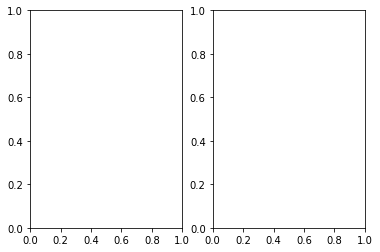

In [26]:
f,(ax1, ax2) = plt.subplots(1,2)

ax1.hist(logAge, bins=40, density=True)
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(logMass, bins=40, density=True)
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')

In [ ]:
df = pd.read_csv("OCcompiled_hasAgeMass.csv")

data = np.vstack((df['logAge'].values, df['logMass'].values))
KDE = gaussian_kde(data)
sample = KDE.resample(size=int(1e5))

nbins = 40

f,(ax1, ax2) = plt.subplots(1,2)
ax1.hist(df['logAge'].values, bins=nbins, density=True)
ax1.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(df['logMass'].values, bins=nbins, density=True)
ax2.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')

lt = 5
lm = 2
values = np.vstack([lt, lm])
print(KDE(values))
#NOTE: the age KDE seems to be missing the edges.  Maybe I should set those to zero automatically?